In [1]:
import cv2
import numpy as np
import torch
from torchvision import models as torchmodels
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

from new_dataprep import get_dataloader
from PIL import Image
import copy
from dataprep import clahe
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, classification_report

use_cuda = True if torch.cuda.is_available() else False

In [2]:
models = {"resnet": None}

model = torchmodels.resnet50(pretrained=True)    
model.fc = torch.nn.Linear(2048, 4)

model.load_state_dict(torch.load("results/2022 01 11 - 13 30 49_/best_model.pt"))
models["resnet"] = copy.deepcopy(model)

In [3]:
dataset_path = "./dataset/"
csv_path = "./csv_files/"
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_size = 224

train_loader, validation_loader, test_loader = get_dataloader(batch_size, dataset_path, csv_path, image_size=image_size, device=device)
num_classes = len(set(test_loader.dataset.target_classes))

def eval(model, loader, device):
    model.eval()
    model.to(device)
    correct = 0
    correct_expl = 0
    total_item = 0
    preds = []
    preds_exp = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            probs = model(data)
            classes = torch.nn.Softmax(1)(probs).max(1, keepdim=True)[1]
            targets.extend(target.to('cpu').numpy().tolist())
            preds.extend(classes.to('cpu').numpy().tolist())
            correct += classes.eq(target.view_as(classes)).sum().item()
            total_item += data.shape[0]
    return classification_report(targets, preds, target_names=["Normal", "COVID-19", "Virus", "bacteria"], digits=3)

for model in models:
    model_ = models[model]
    model_.eval()
    report = eval(model_, test_loader, device)

print("#"*75)
print(report)
print("#"*75)



###########################################################################
              precision    recall  f1-score   support

      Normal      0.973     0.973     0.973       370
    COVID-19      0.976     0.992     0.984       368
       Virus      0.841     0.888     0.863       285
    bacteria      0.891     0.820     0.854       278

    accuracy                          0.927      1301
   macro avg      0.920     0.918     0.919      1301
weighted avg      0.927     0.927     0.927      1301

###########################################################################


In [4]:
images = {"covid": "dataset/COVID-19/COVID-56.png", 
          "bacteria": "dataset/bacteria/person26_bacteria_133.jpeg",
         "normal": "dataset/Normal/IM-0217-0001.jpeg",
         "virus": "dataset/Virus/person99_virus_183.jpeg"}

In [5]:
def preprocess_image(image, mean, std):
    img =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])(image.copy())
    return img.unsqueeze(0)

In [6]:
methods = {"gradcam": GradCAM,
           "layercam": LayerCAM
          }

In [7]:
def get_method_results(model, method, target_layers, image_path, use_cuda):
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224), interpolation=cv2.INTER_AREA)
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    
    targets = None
    model.eval()
    
    with method(model=model,
                target_layers=target_layers,
                use_cuda=use_cuda) as cam:

        cam.batch_size = 1
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=True,
                            eigen_smooth=False)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]
        
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    
    return cam_image

In [8]:
results = []
for method in methods:
    for model in models:
        for image in images:
            target_layers = [models[model].layer4]
                
            result = get_method_results(model=models[model], method=methods[method], 
                                        target_layers=target_layers, 
                                        image_path=images[image], 
                                        use_cuda=use_cuda)
            results.append(result)
      
            

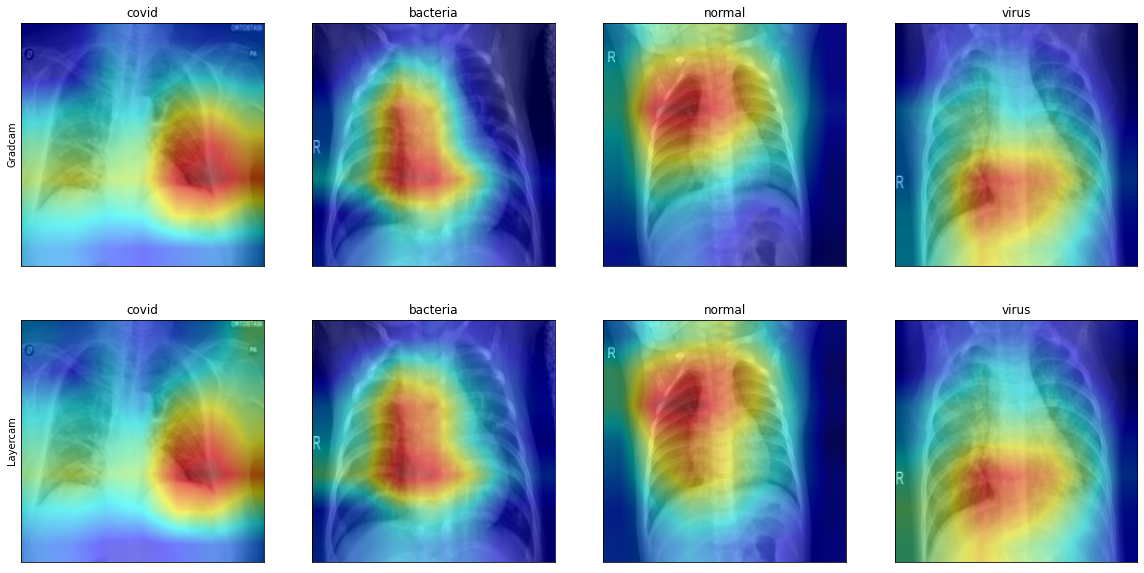

In [9]:
plt.rcParams['figure.figsize'] = [20, 10]
i = 1
for method in methods:
    for model in models:
        for image in images:
            plt.subplot(len(methods), len(images), i)
            plt.imshow(results[i - 1])
            plt.xticks([], [])
            plt.yticks([], [])
            if i % len(images) == 1:
                plt.ylabel(method.capitalize())
            plt.title(image)
            i += 1
plt.show()
